# Term Frequency-Inverse Document Frequency Weight

With the text broken up and excess words eliminated, it's time to assess the value of the remaining text. The "value" of a word is determined by how often it appears in the text. For example, if you were reading an article about technology and the word "Python" appears multiple times, you would assume that Python is important to the subject of the article.

PySpark can apply TF-IDF, a statistical weight showing the importance of a word in a document. Term frequency (TF) measures the frequency of a word occurring in a document, and inverse document frequency (IDF) measures the significance of a word across a set of documents. Multiplying these two numbers would determine the TF-IDF.

Consider the previous example of the technology article. If "Python" appears 20 times in a 1,000-word article, the TF weight would be 20 divided by 1,000 which equals 0.02. Assume that this article resides in a database with other articles, totaling 1,000,000 articles.

IDF takes the number of documents that contain the word Python and compares to the total number of documents, then takes the logarithm of the results. For example, if Python is mentioned in 1000 articles and the total amount of articles in the database is 1,000,000, the IDF would be the log of the total number of articles divided by the number of articles that contain the word Python.

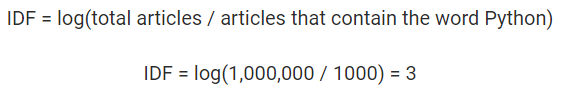

Remember that the log (in base 10) of a number is the power of 10 that raises 10 to that number. So, since 1,000,000 / 1,000 = 1000, and 10 raised to the 3rd power is 1000, the log of 1000 is therefore 3. Now that we have both numbers, we can determine the TF-IDF which is the multiple of the two.

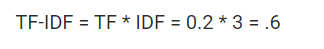

As you might recall, computers deal with numbers, not text, so for a computer to determine the TF-IDF, it needs to convert all the text to a numerical format. There are two possible ways to do so.

The first is by CountVectorizer, which indexes the words across all the documents and returns a vector of word counts corresponding to the indexes. The indexes are assigned in descending order of frequency. For example, the word with the highest frequency across all documents will be given an index of 0, and the word with the lowest frequency will have an index equal to the number of words in the text.

The second method is HashingTF, which converts words to numeric IDs. The same words are assigned the same IDs and then mapped to an index and counted, and a vector is returned. For our Python example, if it gets a numerical ID of 4278 and it appeared 20 times, the vector would be 4278 : 20.

For our project, let's use the HashingTF method for your pipeline for ease of use. It's easier to match up a hashed value for a word and the count of times that word appeared.

Create a new notebook and install PySpark with the following code:

In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.1'
spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TF-IDF").getOrCreate()

Import the following libraries that will be used, and go through both the tokenizer and stop words steps:

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover

This time, we'll work with imported data. This is a dataset of tweets from people directed at an airline. We'll load in the data the same way we did when working with DataFrames earlier:

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://s3.amazonaws.com/dataviz-curriculum/day_2/airlines.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("airlines.csv"), sep=",", header=True)

# Show DataFrame
df.show()

We'll tokenize our data first, as follows:

In [ ]:
# Tokenize DataFrame
tokened = Tokenizer(inputCol="Airline Tweets", outputCol="words")
tokened_transformed = tokened.transform(df)
tokened_transformed.show()

Next, remove the stop words:

In [ ]:
# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
removed_frame = remover.transform(tokened_transformed)
removed_frame.show(truncate=False)

The HashingTF function takes an argument for an input column, an output column, and a numFeature parameter, which specifies the number of buckets for the split words. This number must be higher than the number of unique words. By default, the value is 2^18^or 262,144. The power of two should be used so that indexes are evenly mapped. Here we supply the numFeatures argument with its default value for demonstration. This argument can normally be left out and will use the same value by default.

## NOTE
If the numFeatures is too low to give each word its own individual index then we would get what are called collisions. This is beyond the scope of this class but if you wish to learn more about this please see this wikipedia article: Collision (computer science) 

If you scroll to the right and down, you'll see the hashedValues result, which contains the index and term frequency of the corresponding index for each word.

In [ ]:
# Run the hashing term frequency
hashing = HashingTF(inputCol='filtered, outputCol='hashedValues', numFeatures=pow(2,18))

In [ ]:
# Transform into a DF
hashed_df = hashing.transform(removed_frame)
hased_df.show(truncate=False)

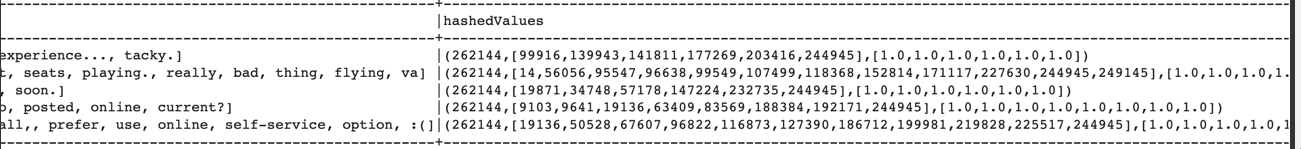

With our words successfully converted to numbers, we can plug it all into an IDFModel, which will scale the values while down-weighting based on document frequency. If you scroll to the right on the output, you'll see the result of the TF-IDF:

In [ ]:
# fit the IDF on the data set
idf = IDF(inputCol='hashedValues', outputCol='features')
idfModel = idf.fit(hashed_df)
rescaledData = idfModel.transform(hashed_df)

In [ ]:
# Display the Dataframe
rescaledData.select('words', 'features').show(truncate=False)

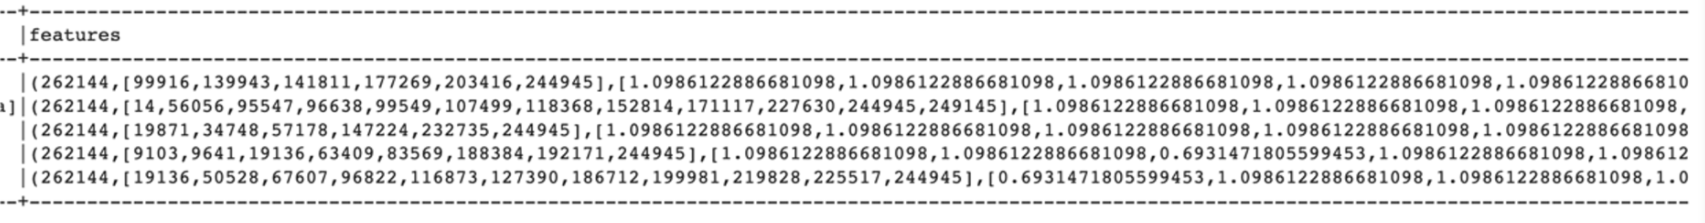

Remember that computers can't just read text and analyze it. With the process we have just completed, we have now given values from raw text that a computer can work with. The next section will put all of this together and show how we can use text data to determine the accuracy of the corresponding rating.